# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение, в котором можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

Набор данных находится в файле `/datasets/insurance.csv`. Он содержит таблицу со следующими столбцами:
- ***DateCrawled*** - дата скачивания анкеты из базы
- ***VehicleType*** - тип автомобильного кузова
- ***RegistrationYear*** - год регистрации автомобиля
- ***Gearbox*** - тип коробки передач
- ***Power*** - мощность (л.с.)
- ***Model*** - модель автомобиля
- ***Kilometer*** - пробег (км)
- ***RegistrationMonth*** - месяц регистрации автомобиля
- ***FuelType*** - тип топлива
- ***Brand*** - марка автомобиля
- ***Repaired*** - была машина в ремонте или нет
- ***DateCreated*** - дата создания анкеты
- ***NumberOfPictures*** - количество фотографий автомобиля
- ***PostalCode*** - почтовый индекс владельца анкеты
- ***LastSeen*** - дата последней активности пользователя
- ***Price*** - цена (евро)

## Предобработка данных

In [1]:
!pip install category_encoders -q

In [2]:
import re
import sys

from category_encoders import BinaryEncoder
from IPython.display import display, HTML
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from tqdm import tqdm

In [3]:
display(HTML("<style>.container { width:90% !important; }</style>")) #широкоформатный режим

In [4]:
RANDOM_STATE = 28072023#константа, инициализирующая генератор псевдослучайных чисел

Откроем файл `autos.csv` и запишем датафрейм в переменную `autos`

In [5]:
def read_dataset(name_csv, **kwargs): 
    if sys.platform == 'linux':
        df = pd.read_csv(f'/datasets/{name_csv}',**kwargs)
    else:
        df = pd.read_csv(f'datasets/{name_csv}',**kwargs)
    return df
autos = read_dataset('autos.csv', parse_dates=['DateCrawled','DateCreated','LastSeen'])

### Первичный анализ данных

Создадим функцию для первичного анализа данных

In [6]:
def exploratory_analysis(df:pd.DataFrame, drop_cols=None):    
    display(HTML("<br><h1 align='center'>Основная информация</h1>"))
    df.info()    
    display(df.describe())
    display(HTML("<br><h1 align='center'>Первые 10 строк</h1>"), df.head(10))    
    display(HTML("<br><h1 align='center'>Корреляция</h1>"))
    if drop_cols:
        display(df.drop(columns=drop_cols).corr(method='spearman'))
    else:
        display(df.corr(method='spearman'))
    display(HTML("<br><h1 align='center'>Гистограммы</h1>"))
    _ = df.hist(figsize=(15,25), bins=20, xrot=90)
    plt.show()
    display(HTML("<br><h1 align='center'>Пропуски</h1>"), df.isna().sum())     

Применим функцию `exploratory_analysis` к датафрейму `autos`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
Price,1.000000,0.550988,0.512604,-0.314412,0.155247,0.078933
RegistrationYear,0.550988,1.000000,0.160182,-0.294567,0.052692,0.034934
Power,0.512604,0.160182,1.000000,0.084509,0.128826,0.081066
Kilometer,-0.314412,-0.294567,0.084509,1.000000,-0.011119,-0.017086
RegistrationMonth,0.155247,0.052692,0.128826,-0.011119,1.000000,0.014935
PostalCode,0.078933,0.034934,0.081066,-0.017086,0.014935,1.000000


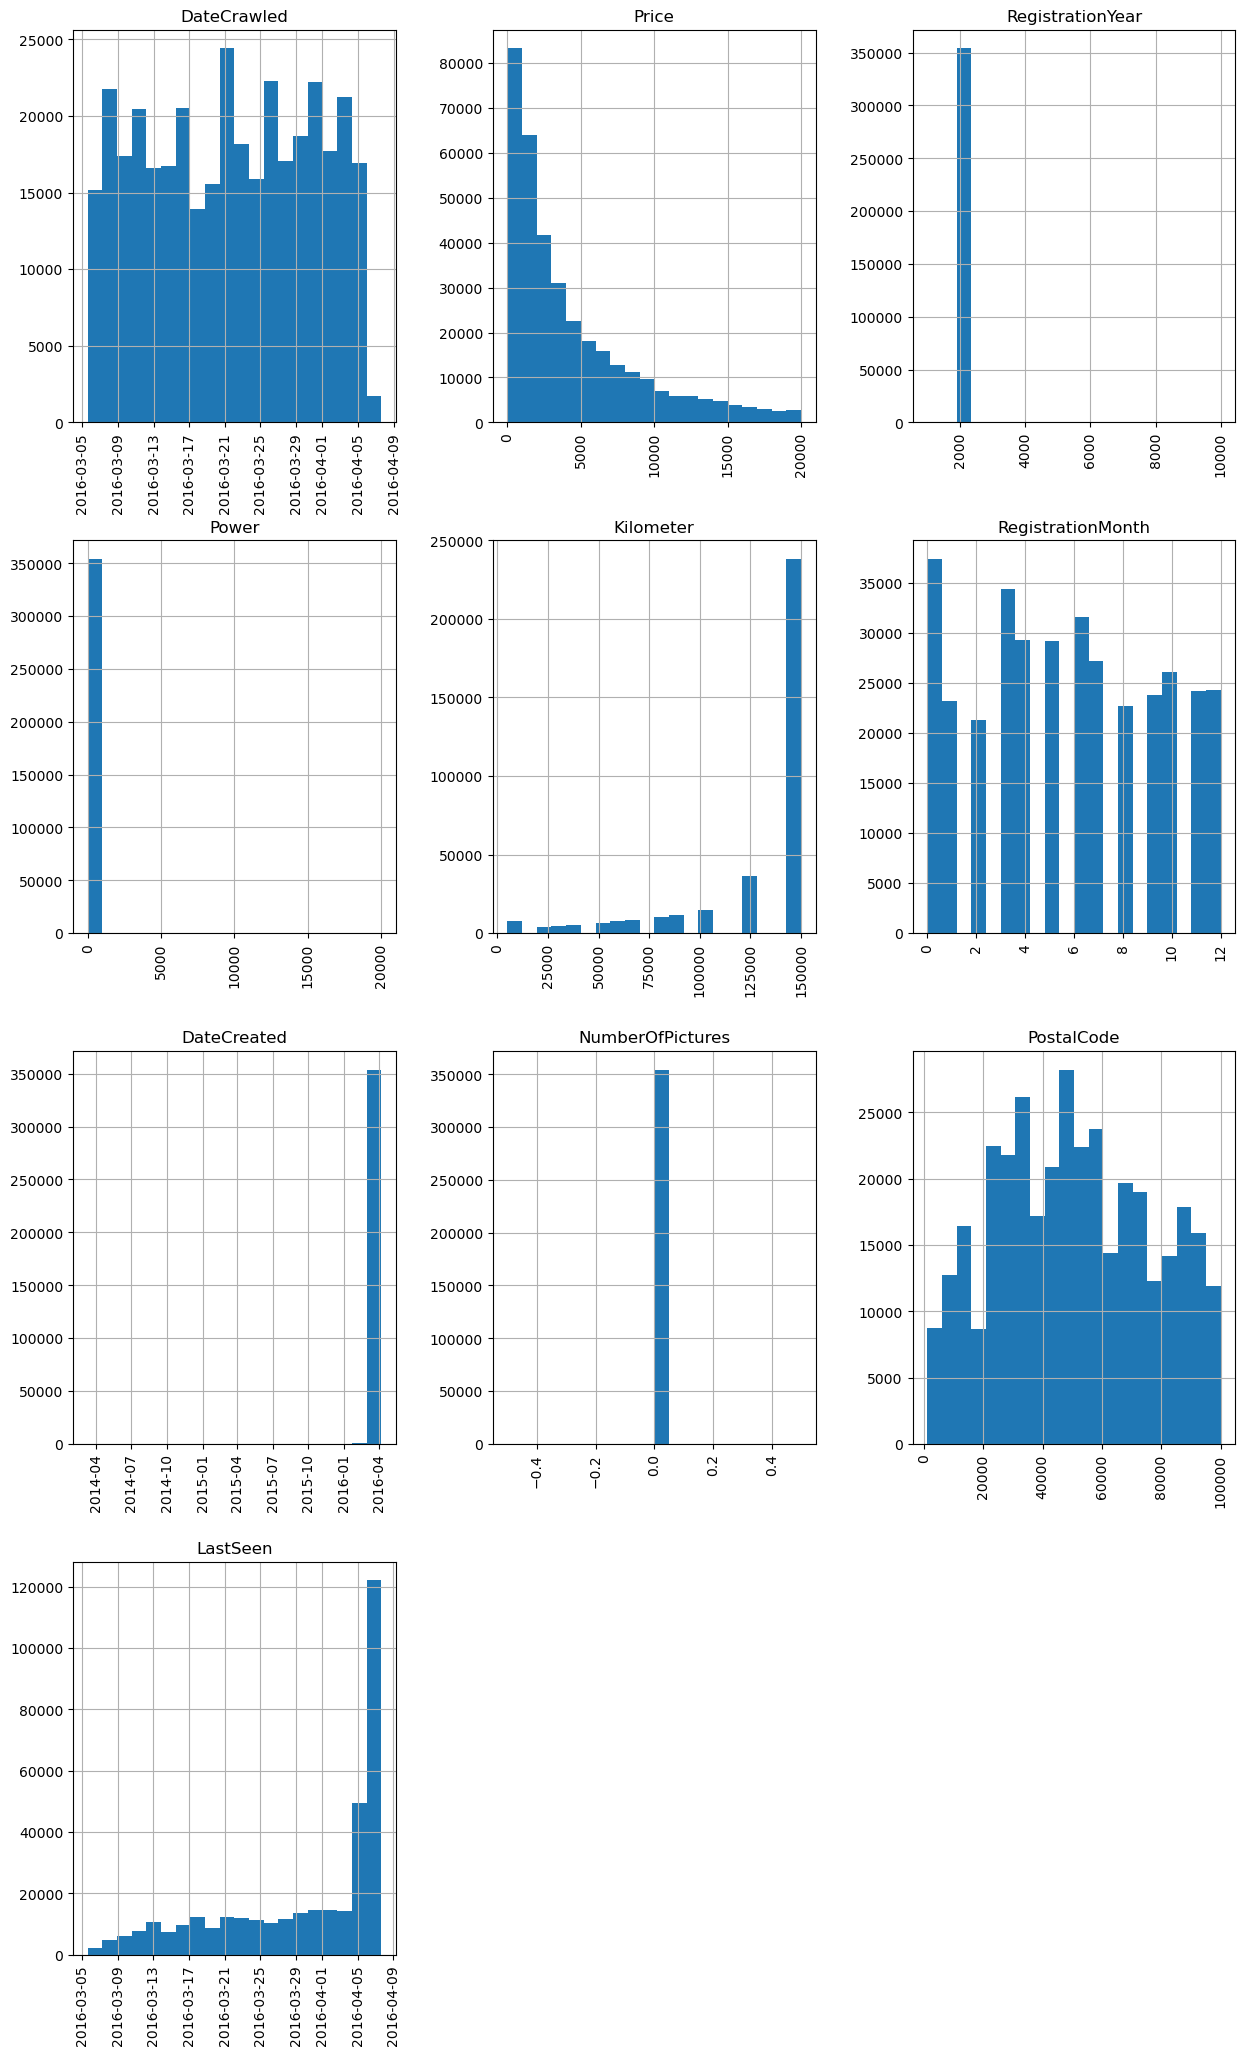

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
exploratory_analysis(autos, ['NumberOfPictures']) #из корреляции уберём столбец NumberOfPictures, т.к. он содержит одни нули

**Выводы:**
1. датафрейм `autos` содержит 354369 строк и 16 столбцов;
1. названия столбцов указаны в стиле `CamelCase` вместо `snake_case`, необходимо переименовать их;
1. столбец `NumberOfPictures` состоит из одних нулей, поэтому его можно удалить;
1. в данных есть аномалии и выбросы;
1. в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` есть пропуски;
1. между столбцами `RegistrationYear` и `Price` средняя положительная связь, между `Power` и `Price` также средняя положительная связь, а между `Kilometer` и `Price` - слабая отрицательная связь.

### Переименование столбцов

Приведём стиль написания названия столбцов `CamelCase` к стилю `snake_case`

In [8]:
autos = autos.rename(columns=lambda column: re.sub(r'(?!^)(?=[A-Z])', '_', column).lower())
list(autos.columns)

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

### Удаление неинформативных столбцов

Определим количество уникальных значений столбца number_of_pictures

In [9]:
autos.number_of_pictures.nunique()

1

Так как во всех строчках присутствует одно и то же число, то данный признак неинформативен, поэтому его можно легко удалить. Так же на цену автомобиля не могут влиять даты последней активности пользователя, а также дата скачивания анкеты из базы

In [10]:
autos = autos.drop(columns=['number_of_pictures','last_seen','date_crawled'], errors='ignore')
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   price               354369 non-null  int64         
 1   vehicle_type        316879 non-null  object        
 2   registration_year   354369 non-null  int64         
 3   gearbox             334536 non-null  object        
 4   power               354369 non-null  int64         
 5   model               334664 non-null  object        
 6   kilometer           354369 non-null  int64         
 7   registration_month  354369 non-null  int64         
 8   fuel_type           321474 non-null  object        
 9   brand               354369 non-null  object        
 10  repaired            283215 non-null  object        
 11  date_created        354369 non-null  datetime64[ns]
 12  postal_code         354369 non-null  int64         
dtypes: datetime64[ns](1), int64(6

### Заполнение пропусков

Заполним пропуски в столбцах `vehicle_type`, `gearbox` и `fuel_type` самым часто встречающимся значением для данной модели, марки и года регистрации

In [11]:
for name, group in tqdm(autos.groupby(['brand','model','registration_year'])):
    for col in ['vehicle_type','gearbox','fuel_type']:
        #проверяем есть ли в столбце из группы пропуски
        cnt_na = group[col].isna().sum()
        if cnt_na==0 or cnt_na==group.shape[0]: #если все значения - без пропусков или одни пропуски
            continue
        else:            
            autos.loc[group.index, col] = group.fillna(group[col].value_counts().idxmax())
autos.isna().sum()

 85%|█████████████████████████████████████████████████████████████████▋           | 6824/8005 [00:12<00:02, 562.51it/s]


price                     0
vehicle_type          20102
registration_year         0
gearbox                4463
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7579
brand                     0
repaired              71154
date_created              0
postal_code               0
dtype: int64

Не все пропуски удалось заменить, оставшиеся пропуски заменим самыми часто встречающимися значениями, без учёта года регистрации

In [12]:
for name, group in tqdm(autos.groupby(['brand','model'])):
    for col in ['vehicle_type','gearbox','fuel_type']:
        #проверяем есть ли в столбце из группы пропуски
        cnt_na = group[col].isna().sum()
        if cnt_na==0 or cnt_na==group.shape[0]: #если все значения - без пропусков или одни пропуски
            continue
        else:            
            autos.loc[group.index, col] = group.fillna(group[col].value_counts().idxmax())
autos.isna().sum()

 88%|█████████████████████████████████████████████████████████████████████▌         | 297/337 [00:02<00:00, 102.87it/s]


price                     0
vehicle_type           6828
registration_year         0
gearbox                4131
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7163
brand                     0
repaired              71154
date_created              0
postal_code               0
dtype: int64

Значения в столбцах `model` и `repaired` восстановить невозможно.

### Обработка аномалий и выбросов

#### Год регистрации автомобиля

В датафрейме год регистрации автомобиля указан находится в диапазоне 1000-9999, явно есть аномалии, поэтому в качесте ориентира возьмём диаграмму размаха

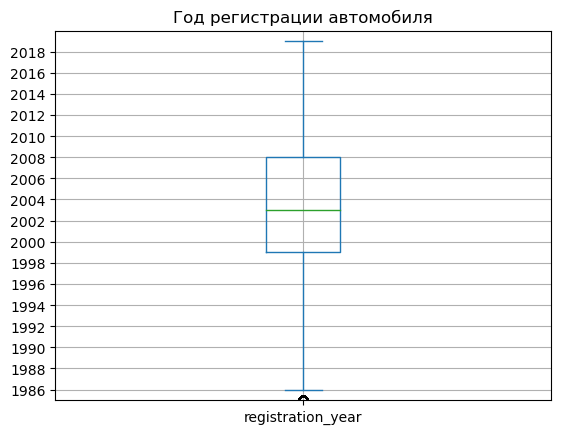

In [13]:
autos.registration_year.plot(kind='box', ylim=[1985,2020], yticks=range(1984,2020,2), grid=True);
plt.title('Год регистрации автомобиля');

По диаграмме размаха видно, что основные даты регистрации автомобилей - в интервале от 1986 до 2019 года. Но т.к. дата создания анкеты и дата последней активности пользователя не превышают 2016 год, то всё, что больше 2016 года необходимо считать аномалией и можно удалить. Посчитаем долю анкет с автомобилями, которые зарегистрированы до 1986 года и после 2016. 2016 год необходимо также удалить, т.к. данные были собраны вначале года, а выставлять на продажу автомобиль со сроком эксплуатации 2-3 месяца бессмысленно.

In [14]:
autos.query('registration_year<1986 or registration_year>=2016').shape[0]/autos.shape[0]*100

8.55972164608078

8.6% не так много, удаляем эти строки

In [15]:
autos = autos.query('registration_year>=1986 and registration_year<2016').reset_index(drop=True)
autos.shape

(324036, 13)

#### Цена автомобиля

Минимальная цена автомобиля равна 0. Скорее всего это сделано для привлечения покупателей и на основе их предложений продавец сформирует свою цену. Так как цену необходимо спрогнозировать, то эти данные плохо подходят к нашей задачи. Посмотрим на поведение гистограммы недалеко от 0

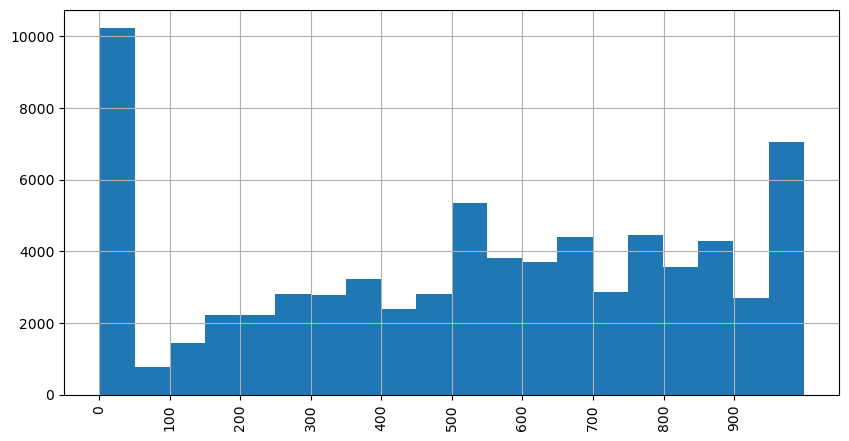

In [16]:
autos.loc[autos.price<1000,'price'].hist(bins=20, figsize=(10,5), xrot=90)
plt.xticks(range(0,1000,100));
plt.show()

В качестве границы возьмём 100 евро, посчитаем долю этих данных

In [17]:
autos[autos.price<100].shape[0]/autos.shape[0]*100

3.3993136565073017

Удаляем эти строки

In [18]:
autos = autos[autos.price>=100]
autos.shape

(313021, 13)

#### Мощность автомобиля

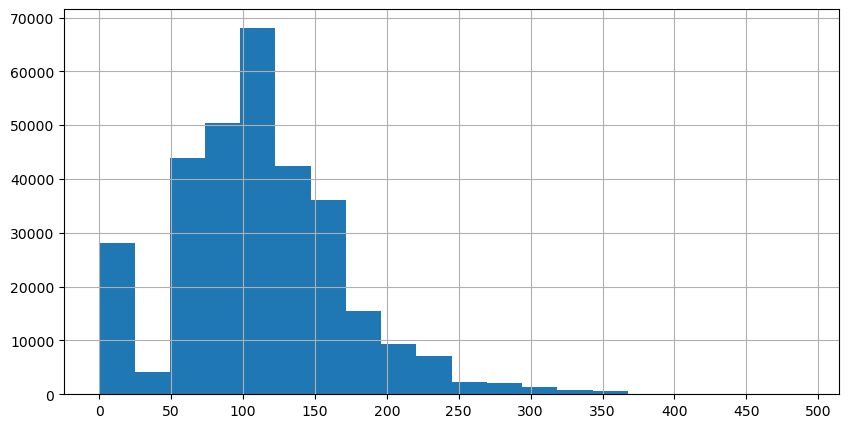

In [19]:
autos.loc[autos.power<500, 'power'].hist(bins=20, figsize=(10,5));
plt.xticks(range(0,550,50));

Изменим масштаб по оси y для того, чтобы лучше увидеть верхнюю границу диапазона мощности автомобилей

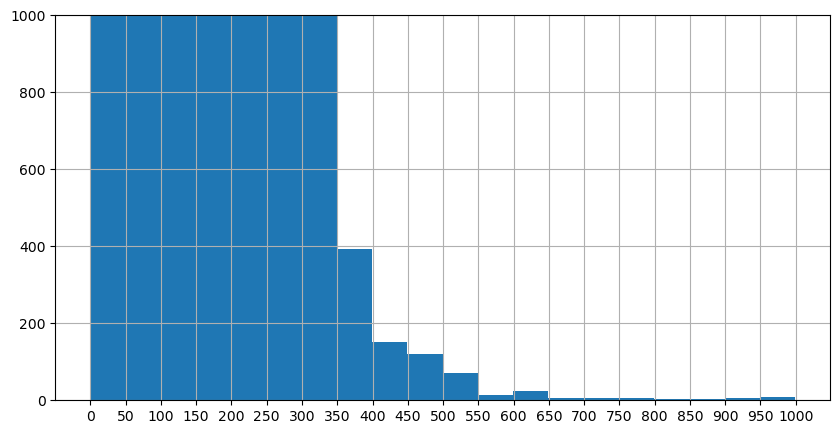

In [20]:
autos.loc[autos.power<1000, 'power'].hist(bins=20, figsize=(10,5));
plt.xticks(range(0,1050,50));
plt.ylim([0,1000]);

Очевидно, что значения меньше 50 и больше 600 - это аномальные значения, посчитаем их долю

In [21]:
anomal_power = autos.loc[(autos.power<50)| (autos.power>600)]
anomal_power.shape[0]/autos.shape[0]*100

10.37853690327486

Сгруппируем по модели, бренду и году регистрации, а потом заполним средним значением, характерным для данной группы

In [22]:
autos_model_power = (autos.drop(index=anomal_power.index)
                     .groupby(['brand','model','registration_year'])['power']
                     .agg(['sum','count'])
                     .rename(columns={'sum':'sum_power', 'count':'count_power'})
                     .reset_index(level='registration_year')
                    )
for name, group in tqdm(anomal_power.groupby(['brand','model','registration_year'])): 
    if (name[0], name[1]) in autos_model_power.index:
        power_by_model = autos_model_power.loc[(autos_model_power.index==(name[0], name[1]))]
        power_by_year = power_by_model.loc[power_by_model.registration_year==name[2]] 
        mean_power = (power_by_year.sum_power/power_by_year.count_power).mean()
        if mean_power is np.nan or mean_power<50 or mean_power>600:            
            mean_power = power_by_model.sum_power.sum()/power_by_model.count_power.sum()        
        autos.loc[group.index,'power'] = int(np.round(mean_power))
del autos_model_power
autos.loc[(autos.power<50)| (autos.power>600)].shape[0]/autos.shape[0]*100

 85%|█████████████████████████████████████████████████████████████████▋           | 3039/3562 [00:03<00:00, 942.02it/s]


1.1858629293242307

Удалим оставшиеся аномальные значения

In [23]:
autos = autos[(autos.power>=50) & (autos.power<=600)].reset_index(drop=True)
autos.shape

(309309, 13)

#### Месяц регистрации

Минимальное значение месяца регистрации - 0, заменим его на самый часто встречающийся месяц

In [24]:
autos.loc[autos.registration_month==0,'registration_month'] = int(autos.registration_month.mode())
autos.loc[autos.registration_month==0,'registration_month'].shape[0]

0

#### Дата создания анкеты

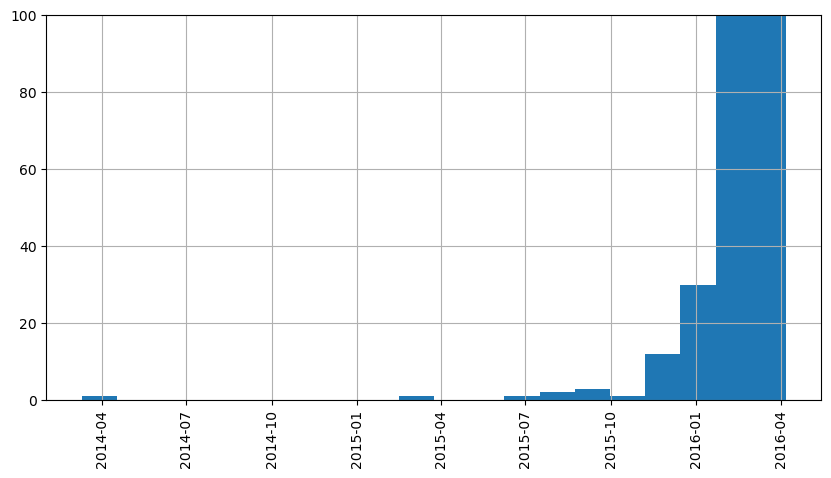

In [25]:
autos.date_created.hist(figsize=(10,5), bins=20, xrot=90)
plt.ylim([0,100]);

Основная часть анкет приходится на временной интервал 10.2015 - 04.2016. При этом есть анкеты и 2014 года, которорые пользователи по той или иной причине не удалили, но т.к. временной период достаточно близок к 2016 году, то нет смысла его удалять.

### Объединение столбцов `registration_year` и `registration_month`

Так как в конечном итоге важен возраст автомобиля, а не конкретный месяц регистрации, то объединим два столбца

In [26]:
autos['registration_date'] = pd.to_datetime({'year':autos.registration_year, 'month':autos.registration_month, 'day':1})
autos = autos.drop(columns=['registration_year','registration_month'])
autos.shape

(309309, 12)

### Удаление дубликатов

Посчитаем количество дубликатов

In [27]:
autos.duplicated().sum()

9690

Количество небольшое относительно всего датасета, удалим их

In [28]:
autos = autos.drop_duplicates().reset_index(drop=True)
autos.shape

(299619, 12)

### Результаты предобработки

Посмотрим, что получилось после предобработки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299619 entries, 0 to 299618
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              299619 non-null  int64         
 1   vehicle_type       298935 non-null  object        
 2   gearbox            299107 non-null  object        
 3   power              299619 non-null  int64         
 4   model              290529 non-null  object        
 5   kilometer          299619 non-null  int64         
 6   fuel_type          297609 non-null  object        
 7   brand              299619 non-null  object        
 8   repaired           250065 non-null  object        
 9   date_created       299619 non-null  datetime64[ns]
 10  postal_code        299619 non-null  int64         
 11  registration_date  299619 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 27.4+ MB


,price,power,kilometer,postal_code
count,299619.000000,299619.000000,299619.000000,299619.000000
mean,4687.264993,120.776406,128948.464550,50985.351516
std,4547.863530,52.557508,36461.626093,25768.469690
min,100.000000,50.000000,5000.000000,1067.000000
25%,1250.000000,78.000000,125000.000000,30655.000000
50%,2999.000000,112.000000,150000.000000,49757.000000
75%,6795.000000,150.000000,150000.000000,71665.000000
max,20000.000000,600.000000,150000.000000,99998.000000


,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,postal_code,registration_date
0,480,sedan,manual,87,golf,150000,petrol,volkswagen,NaN,2016-03-24,70435,1993-03-01
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,66954,2011-05-01
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,90480,2004-08-01
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,91074,2001-06-01
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,60437,2008-07-01
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,2016-04-04,33775,1995-10-01
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,2016-04-01,67112,2004-08-01
7,14500,bus,manual,125,c_max,30000,petrol,ford,NaN,2016-04-04,94505,2014-08-01
8,999,small,manual,101,golf,150000,petrol,volkswagen,NaN,2016-03-17,27472,1998-03-01
9,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no,2016-03-26,96224,2004-12-01


,price,power,kilometer,postal_code
price,1.000000,0.527849,-0.353333,0.071830
power,0.527849,1.000000,0.117874,0.064479
kilometer,-0.353333,0.117874,1.000000,-0.021695
postal_code,0.071830,0.064479,-0.021695,1.000000


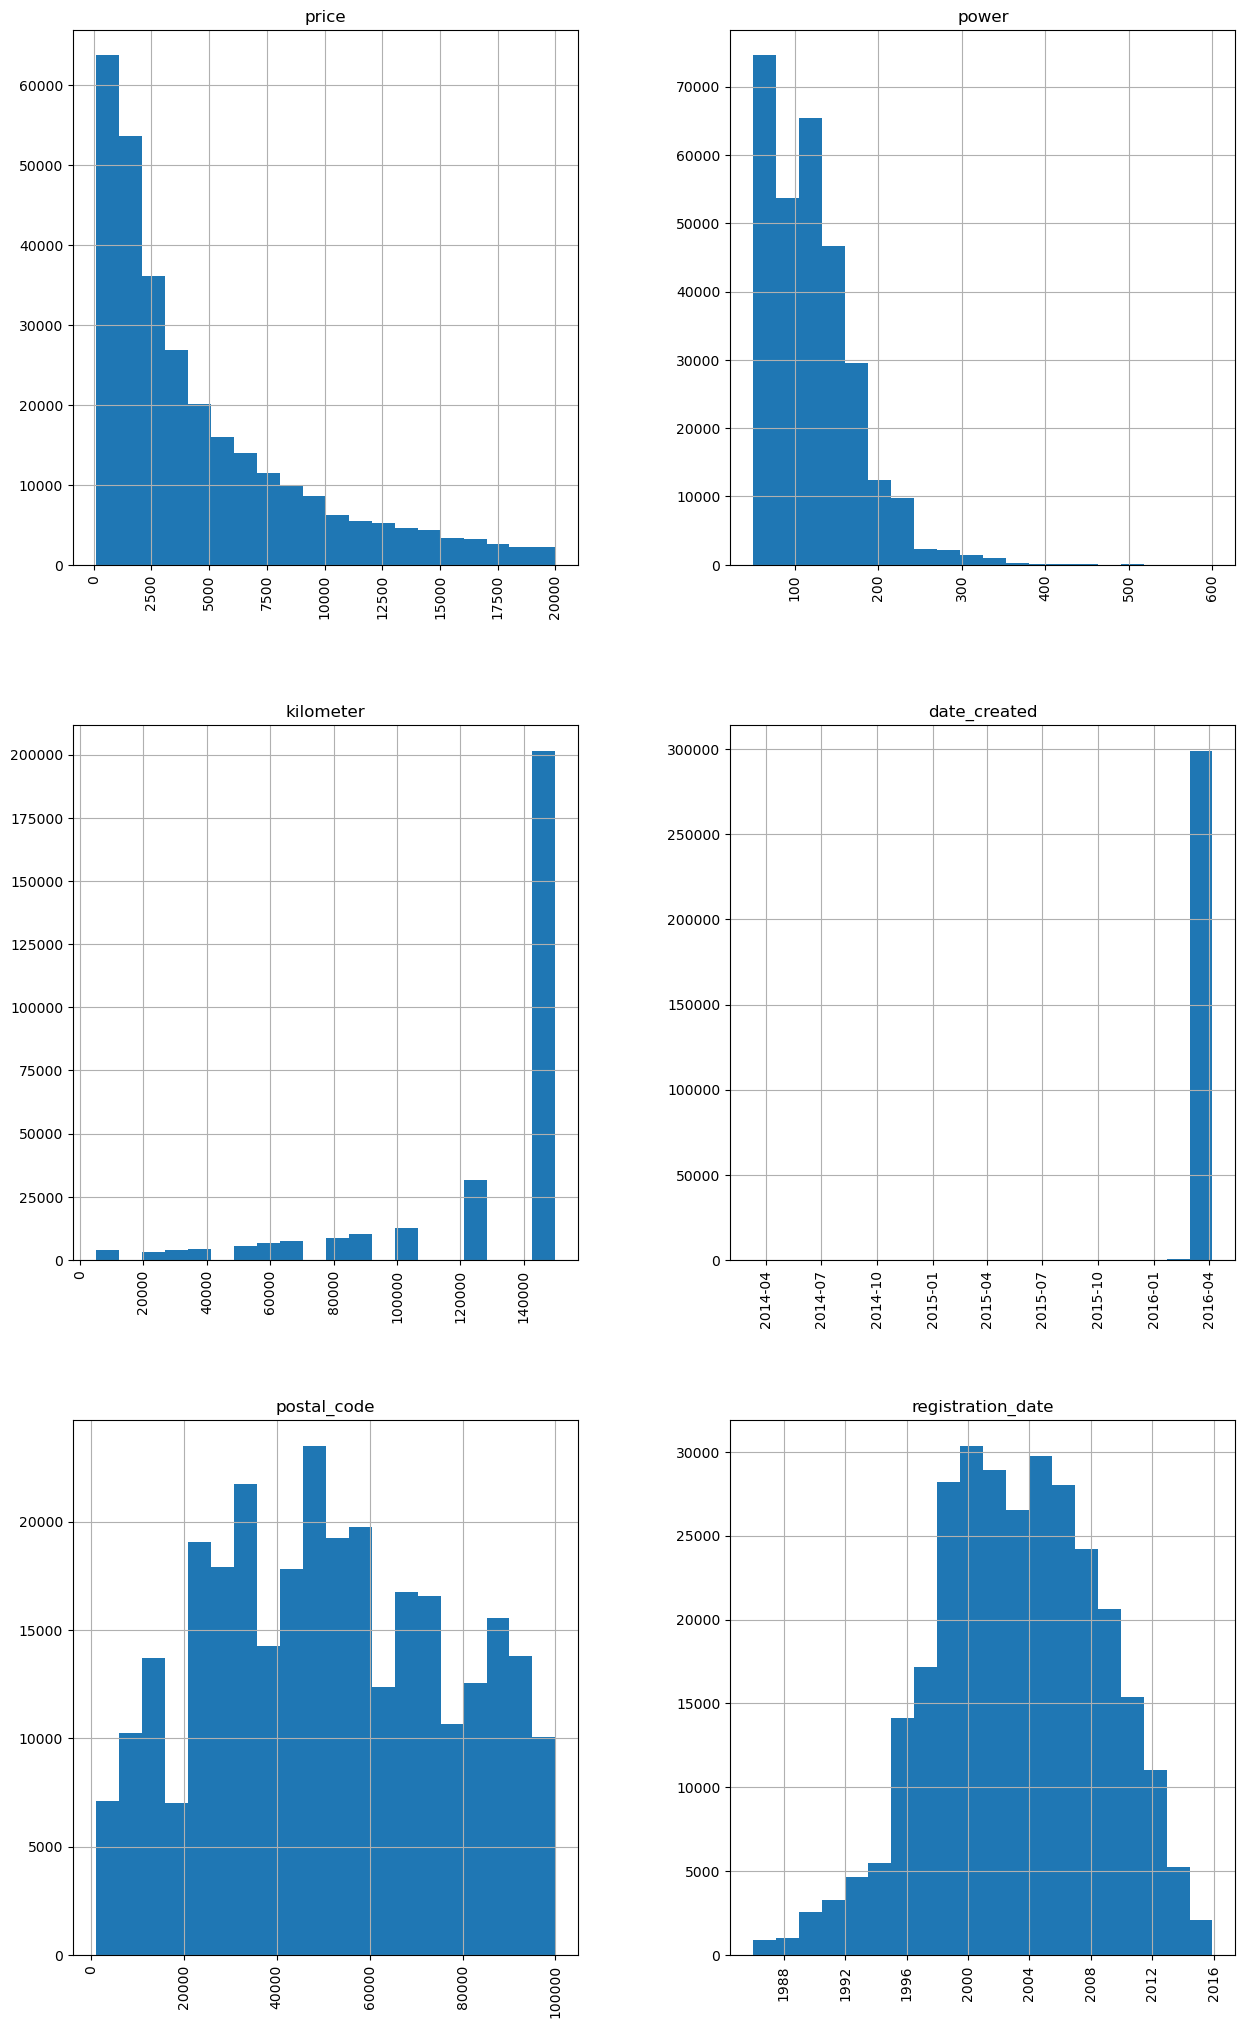

price                    0
vehicle_type           684
gearbox                512
power                    0
model                 9090
kilometer                0
fuel_type             2010
brand                    0
repaired             49554
date_created             0
postal_code              0
registration_date        0
dtype: int64

In [29]:
exploratory_analysis(autos)

**В результате подготовки данных была проделана следующая работа:**
1. изменён стиль названия столбцов с `CamelCase` на `snake_case`;
1. удалены неинформативные столбцы `number_of_pictures`,`last_seen`,`date_crawled`;
1. удалены дубликаты;
1. заполнены пропуски в столбцах `vehicle_type`, `gearbox` и `fuel_type`;
1. обработаны аномалии в годе регистрации, месяце регистрации, цене и мощности автомобиля, а также устранены выбросы в дате создания анкеты;
1. объединены столбцы `registration_year` и `registration_month` в `registration_date`.

**Таким образом, после предобработки данных в датафрейме `autos` осталось 299619 строк и 12 столбцов.**

## Обучение моделей

### Подготовка данных

#### Разбивка выборки на обучающую и тестовую

Разобьём данные на обучающую и тестовую выборки. Так как данных достаточно много, то возьмём соотношение 80:20

In [30]:
features = autos.drop(columns='price')
target = autos.price
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.8, random_state=RANDOM_STATE)

#для устранения предупреждения от кодировщиков
features_train=features_train.copy()
features_test=features_test.copy()
len(features_train), len(features_test), len(target_train), len(target_test)

(239695, 59924, 239695, 59924)

#### Кодирование категориальных признаков

Напечатаем количество уникальных значений по каждому категориальному признаку, включая пропуски

In [31]:
for col in ['vehicle_type','gearbox','model','fuel_type','brand','repaired','postal_code']:
    print(f'{col}: {autos[col].nunique(dropna=False)}')

vehicle_type: 9
gearbox: 3
model: 248
fuel_type: 8
brand: 40
repaired: 3
postal_code: 8117


Исходя из количества уникальных значений, применим для `vehicle_type`, `model`, `fuel_type` и `brand` бинарное кодирование, для `gearbox` и `repaired` - прямое кодирование. Учитывая, что близкие значения почтовых индексов обычно обозначают близкие территории, оптимальным способом приведения данного столбца к диапазону [0,1] будет `MinMaxScaler`.

In [32]:
be_cols = ['vehicle_type', 'model', 'fuel_type','brand']
be = BinaryEncoder()
be.fit(features_train[be_cols])
features_train[be.get_feature_names_out()] = be.transform(features_train[be_cols])
features_test[be.get_feature_names_out()] = be.transform(features_test[be_cols])

ohe_cols = ['gearbox', 'repaired']
ohe = OneHotEncoder(drop='first', sparse=False, dtype='int')
ohe.fit(features_train[ohe_cols])
features_train[ohe.get_feature_names(ohe_cols)] = ohe.transform(features_train[ohe_cols])
features_test[ohe.get_feature_names(ohe_cols)] = ohe.transform(features_test[ohe_cols])

mms_cols = ['postal_code']
mms = MinMaxScaler()
features_train[mms_cols] = mms.fit_transform(features_train[mms_cols])
features_test[mms_cols] = mms.transform(features_test[mms_cols])

features_train = features_train.drop(columns = be_cols + ohe_cols)
features_test = features_test.drop(columns = be_cols + ohe_cols)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Масштабирование признаков

Приведём даты к целочисленному типу

In [33]:
date_cols = ['registration_date','date_created']
features_train[date_cols] = features_train[date_cols].astype('int64')
features_test[date_cols] = features_test[date_cols].astype('int64')
features_train[date_cols].dtypes, features_test[['registration_date','date_created']].dtypes

(registration_date    int64
 date_created         int64
 dtype: object,
 registration_date    int64
 date_created         int64
 dtype: object)

Так как признаки имёют разный масштаб, то отмасштабируем числовые признаки

In [34]:
numeric = ['registration_date','power', 'kilometer','date_created']
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Линейная регрессия

В линейной регрессии подберём 2 гиперпараметра, отвечающих за регуляризацию: `alpha` и `l1_ratio`

In [35]:
%%time
best_lr_model = RandomizedSearchCV(estimator=ElasticNet(selection='random', random_state=RANDOM_STATE),
                                  param_distributions={'alpha':np.arange(0.1,1.0,0.1),
                                                      'l1_ratio':np.arange(0.1,1.0,0.1)},
                                  scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE,
                                  verbose=2, n_jobs=-1
                                 )
best_lr_model.fit(features_train, target_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 11.4 s


RandomizedSearchCV(estimator=ElasticNet(random_state=28072023,
                                        selection='random'),
                   n_jobs=-1,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=28072023, scoring='neg_root_mean_squared_error',
                   verbose=2)

### Дерево решений

В модели дерева решений подберём следующие гиперпараметры:
- max_depth (максимально допустимая глубина дерева)
- min_samples_split (минимальное количество примеров для разделения)
- max_leaf_nodes (максимальное количество листовых узлов)

In [36]:
%%time
best_dt_model = RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
                                  param_distributions={'max_depth':list(range(2,20,2))+[None], 'min_samples_leaf': range(2,22,2), 
                                                       'max_leaf_nodes': list(range(10,110,10))+[None]},
                                  scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, 
                                  verbose=2, n_jobs=-1
                                 )
best_dt_model.fit(features_train, target_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 5.57 s


RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=28072023),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, None],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           None],
                                        'min_samples_leaf': range(2, 22, 2)},
                   random_state=28072023, scoring='neg_root_mean_squared_error',
                   verbose=2)

### Градиентный бустинг

В модели градиентного бустинга подберём следующие гиперпараметры:
- boosting_type (тип бустинга)
- max_depth (максимальная глубина дерева)
- num_leaves (максимальное количество листьев для базовой модели)
- n_estimators (количество деревьев)

In [37]:
%%time
best_lgbm_model = RandomizedSearchCV(estimator=LGBMRegressor(random_state=RANDOM_STATE,force_row_wise=True),
                                  param_distributions={
                                                       'boosting_type':['gbdt','dart'],
                                                       'max_depth':range(10), 
                                                       'num_leaves':range(5,50,5),
                                                       'n_estimators': range(10,200,10)
                                                      },
                                  scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, 
                                  verbose=2, n_jobs=-1
                                 )
best_lgbm_model.fit(features_train, target_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 239695, number of used features: 31
[LightGBM] [Info] Start training from score 4685.869835
Wall time: 18.3 s


RandomizedSearchCV(estimator=LGBMRegressor(force_row_wise=True,
                                           random_state=28072023),
                   n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'max_depth': range(0, 10),
                                        'n_estimators': range(10, 200, 10),
                                        'num_leaves': range(5, 50, 5)},
                   random_state=28072023, scoring='neg_root_mean_squared_error',
                   verbose=2)

## Анализ моделей

### Сравнение моделей по скорости работы и значению метрики

Время обучения

In [38]:
%time best_lr_model.best_estimator_.fit(features_train, target_train);
print('-'*20)
%time best_dt_model.best_estimator_.fit(features_train, target_train);
print('-'*20)
%time best_lgbm_model.best_estimator_.fit(features_train, target_train);

Wall time: 725 ms
--------------------
Wall time: 952 ms
--------------------
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 239695, number of used features: 31
[LightGBM] [Info] Start training from score 4685.869835
Wall time: 617 ms


LGBMRegressor(force_row_wise=True, max_depth=7, n_estimators=190, num_leaves=15,
              random_state=28072023)

Время предсказания

In [39]:
%time best_lr_model.best_estimator_.predict(features_train);
print('-'*20)
%time best_dt_model.best_estimator_.predict(features_train);
print('-'*20)
%time best_lgbm_model.best_estimator_.predict(features_train);

Wall time: 38.3 ms
--------------------
Wall time: 70 ms
--------------------
Wall time: 243 ms


array([1265.09245231, 2213.50545837, 1884.47005561, ..., 3587.71174157,
       9849.52761947, 3629.7815804 ])

Значение метрики RMSE

In [40]:
-np.round([best_lr_model.best_score_, best_dt_model.best_score_, best_lgbm_model.best_score_])

array([2563., 2014., 1667.])

**Выводы:**
1. самая быстрая модель по времени обучения - градиентный бустинг, самая же быстрая по времени предсказания - линейная модель, градиентный бустинг предсказывает гораздо дольше, чем линейная модель или дерево решений 
1. самое лучшее качество у модели - градиентного бустинга, модель линейной регрессии немного не вписывается в заданный критерий RMSE<2500
1. учитывая, что кроме качества модели, важна и скорость работы, то остановимся на модели дерева решений
1. критерии отбора модели сформулированы нечётко, поэтому для подбора более идеальной модели желательно их уточнить

### Тестирование наилучшей модели

Рассчитаем RMSE для модели дерева решений на тестовой выборке

In [41]:
round(mean_squared_error(target_test, best_dt_model.predict(features_test), squared=False))

2003

**RMSE на тестовой выборке почти не отличается от RMSE на обучающей выборке, что говорит о стабильности работы модели**

### Проверка обученной модели на адекватность

Проверим обученную модель дерева решений на адекватность, сравнив значения метрики RMSE у дерева решений и константной модели 

In [42]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
round(mean_squared_error(target_test, dummy_model.predict(features_test), squared=False))

4554

**Ошибка у константной модели более чем в 2 раза больше, чем у обученной модели дерева решений. Таким образом, полученная модель дерева решений является адекватной и её можно внедрять в продакшен**

## Общие выводы

В процессе исследования была проведена следующая работа :
- проведён первичный анализ данных (EDA);
- поменян стиль написания названия столбцов с `CamelCase` на `snake_case`;
- удалены неинформативные столбцы `number_of_pictures`, `last_seen` и `date_crawled`;
- удалены дубликаты;
- заполнены пропуски в столбцах `brand`, `model` и `registration_year`];
- обработаны аномалии и выбросы в столбцах `registration_year`, `price`, `power`, `registration_month` и `date_created`;
- объединены столбцы `registration_year` и `registration_month` в столбец `registration_date`;
- данные были разбиты на обучающую и тестовую выборки в соотношениии 80:20;
- закодированы категориальные признаки с применением бинарного и прямого кодирования;
- отмасштабированы признаки с помощью `MinMaxScaler` и `StandardScaler`;
- проведён подбор гиперпараметров и обучение моделей линейной регресии, дерева решений и градиентного спуска с помощью `RandomizedSearchCV`;
- проведено тестирование и проверка на адекватность наилучшей модели.

В процессе моделирования были получены следующие результаты:
- больше всего времени на обучение затрачивает модель `DecisionTreeRegressor`, чуть побыстрее модель `ElasticNet`, самая быстрая модель - `LightGBM`;
- время предсказания модели линейной регрессии и дерева решений примерно одинаково, модель градиентного бустинга занимает гораздо больше времени на это;
- обученная модель линейной регресии на кросс-валидации показала значение RMSE равное 2563, модель дерева решений - 2014, модель градиентного спуска - 1667;
- модель дерева решений на тестовых данных показала значение RMSE=2003;
- константная модель на тестовой выборке показала RMSE=4554.

В результате проделанной работы можно сформулировать следующие выводы:
1. в столбцах `registration_year`, `price`, `power`, `registration_month` встречаются аномальные значения, необходимо выяснить причину их появления;
1. учитывая, что кроме качества модели, важна и скорость работы, наилучшей моделью будет **дерево решений**;
1. критерии отбора модели сформулированы нечётко, поэтому для подбора более идеальной модели необходимо их уточнить;
1. обученная модель **дерева решений** показала значения метрики на тесте гораздо лучше, чем константная модель.